# Exploring Popular Data Science Questions

Here we look into a Data Science website called Stack Exchange that provides a forum environment where people can ask questions about a multitude of topics related to data science. 
There is also a section for unanswered questions. This can be useful for those looking to offer their help.

Outside of just questions, one can also find a link to jobs that takes them to a Stack Overflow site with job postings. 

There is also an option to filter by tags. For instance, if you wanted to read posts only about machine-learning you could select that tag to filter the posts based on that. 


Our goal here is to look for the most popular content. 
We can use the tags section on the website as a filter.

StackExchange provides a public database for it's websites. We can use the StackExchange Data Explorer to query and select tables in that databse that we are lookiong for. 
A good way to look for popular posts is to select the tags that have the most posts. Doing this in SEDE shows some of the top tags to be machine-learning, classification, and data-mining. 

We startby looking at the post type with the most interaction: questions. Within questions (Where PostTpyeId = 1). Within questions, we can select for the ones from 2019.


SELECT ID, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
  FROM posts
  WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;

In [469]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [470]:
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

In [471]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


In [472]:
questions.isnull().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

The table we queried can be read into a dataframe which we can explore further here.
Upon initial obsevation, we can see that the only null values come from the FavoriteCount column. 
A null value here probably means the question was not listed on the users' favorite list. In this case we can fill the null values with zeros instead.

The type for each column is adequate, and after filling the FavoriteCount column with zeros we can switch that from a float to an int.

In [473]:
questions['FavoriteCount'] = questions['FavoriteCount'].fillna(0).astype(int)

In [474]:
questions['Tags'].unique()

array(['<machine-learning><data-mining>',
       '<machine-learning><regression><linear-regression><regularization>',
       '<python><time-series><forecast><forecasting>', ...,
       '<machine-learning><deep-learning><perceptron>',
       '<pca><dimensionality-reduction><linear-algebra>',
       '<keras><weight-initialization>'], dtype=object)

Looking at the tags column, we can separate the individual tags a little better.

In [475]:
questions['Tags'] = questions['Tags'].str.replace("^<|>$", "").str.split("><")

In [476]:
questions.sample(8)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
8694,55676,2019-07-15 07:42:18,0,13,"[machine-learning, algorithms]",0,0
6931,43461,2019-01-04 00:42:42,1,99,"[machine-learning, time-series, feature-engine...",1,0
253,56062,2019-07-20 15:40:58,0,36,"[machine-learning, clustering, recommender-sys...",3,0
7101,54005,2019-06-18 09:39:09,1,291,"[machine-learning, neural-network, tensorflow,...",1,0
527,56430,2019-07-26 11:03:10,0,21,"[deep-learning, optimization, backpropagation,...",0,0
7763,65018,2019-12-17 16:40:51,2,17,"[machine-learning-model, orange]",0,0
3612,49059,2019-04-10 14:42:05,0,416,"[python, data-cleaning, numpy]",0,0
7922,44017,2019-01-15 09:27:31,0,67,"[neural-network, lstm, training, overfitting, ...",1,1


In [477]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB


We now want to look at determining the most popular tags. We can do this by looking at two things: the number of times a tag was viewed and the number of times a tag was used.

In [478]:
tag_count= {}

for tags in questions['Tags']:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1       

In [479]:
tag_count = pd.DataFrame.from_dict(tag_count, orient="index")
tag_count.rename(columns={0: "Count"}, inplace=True)

most_used = tag_count.sort_values("Count", ascending=False).head(20)
most_used_tail = tag_count.sort_values("Count").tail(20)
most_used

,Count
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935
classification,685
tensorflow,584
scikit-learn,540
nlp,493
cnn,489


In the above we were aiming to produce a table showing the tags with the most use. 
We first created a dictionary and sorted through the tags, adding a count to the associated tag everytime the tag came up when we iterated through the data set. 
We then converted the dictionary into a dataframe and sorted the values based on count to produce the table above.

We can also introduce a graph to help visualize this table.

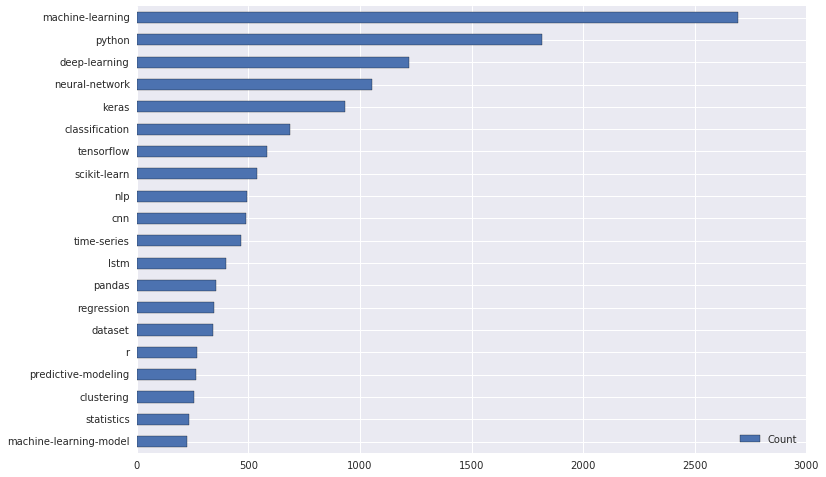

In [480]:
most_used_tail.plot(kind='barh', figsize=(12,8))

Now we can also sort the values based on the number of times each tag was viewed.

In [481]:
tag_views = {}

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_views:
            tag_views[tag] += row["ViewCount"]
        else:
            tag_views[tag] = row["ViewCount"]
            
tag_views = pd.DataFrame.from_dict(tag_views, orient="index")
tag_views.rename(columns={0: "ViewCount"}, inplace=True)

most_viewed = tag_views.sort_values("ViewCount", ascending=False).head(20)
most_viewed_tail = tag_views.sort_values("ViewCount").tail(20)
most_viewed

,ViewCount
python,537585
machine-learning,388499
keras,268608
deep-learning,233628
pandas,201787
neural-network,185367
scikit-learn,128110
tensorflow,121369
classification,104457
dataframe,89352


Just like with the use cases, we can visualize the table with a graph.

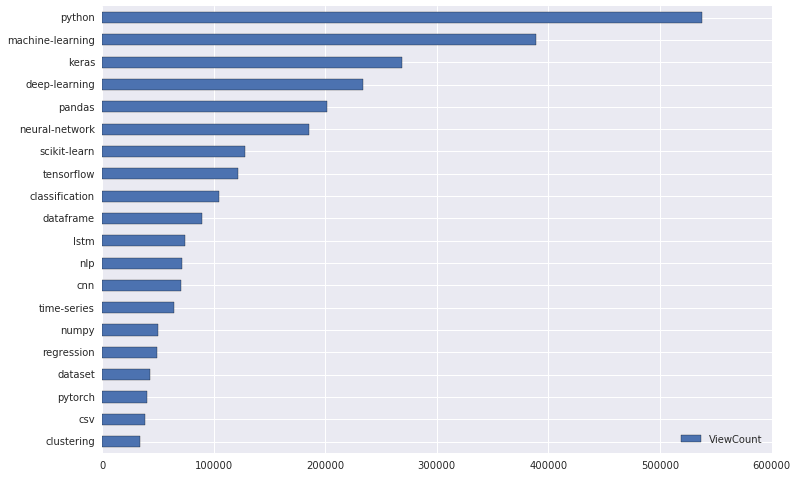

In [482]:
most_viewed_tail.plot(kind='barh', figsize=(12,8))

# Relations between Tags

Another step we can take is seeing how the tags in the highest used relate to the ones in most viewed.

We first create a dataframe called associations that shows all of the tags used in the questions dataset. 
We can then fill the values with zeros and iterate through the questions['Tags'] column. For every set of tags listed in each row of that column, we add 1 to the associations dataframe under the row and column of the tags found. 
We then have a filled associations dataframe showing the relationships of all the tags used in questions and how many times they were used together.

In [483]:
all_tags = list(tag_count.index)
all_tags

associations = pd.DataFrame(index=all_tags, columns=all_tags)

associations.fillna(0, inplace=True)
associations

,reference-request,dplyr,sensors,sequence,pip,stacked-lstm,probabilistic-programming,lda,dirichlet,representation,...,colab,career,features,books,adaboost,scala,learning-to-rank,bayesian,bigdata,image
reference-request,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dplyr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sensors,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sequence,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
stacked-lstm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
probabilistic-programming,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lda,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dirichlet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
representation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [484]:
for tags in questions['Tags']:
    associations.loc[tags,tags] += 1

This is a huge dataframe. We can reduce that down to the specific ones we were looking at earlier.

We can filter this huge dataframe to only show the relationship between the most used and the most viewed tags to show how many times a tag from most used was also used with a tag from most viewed.

This metric allows us to identify the more popular tags overall.

In [485]:
relations_most_popular = associations.loc[most_used.index,most_viewed.index]

In [486]:
relations_most_popular

,python,machine-learning,keras,deep-learning,pandas,neural-network,scikit-learn,tensorflow,classification,dataframe,lstm,nlp,cnn,time-series,numpy,regression,dataset,pytorch,csv,clustering
machine-learning,499,2693,195,429,62,366,188,106,259,6,71,113,124,131,24,119,99,25,3,61
python,1814,499,280,160,244,137,235,167,98,51,61,71,62,105,71,59,53,41,17,45
deep-learning,160,429,247,1220,1,305,16,136,59,0,103,72,160,44,10,21,32,41,1,2
neural-network,137,366,235,305,1,1055,24,108,65,0,69,24,118,33,11,42,20,26,0,8
keras,280,195,935,247,3,235,34,256,58,0,133,23,116,51,11,31,13,12,2,0
classification,98,259,58,59,3,65,47,20,685,1,20,35,20,25,4,34,28,2,1,12
tensorflow,167,106,256,136,3,108,15,584,20,0,43,11,57,9,13,9,9,18,0,0
scikit-learn,235,188,34,16,37,24,540,15,47,2,2,12,0,12,12,37,9,2,0,24
nlp,71,113,23,72,3,24,12,11,35,0,19,493,7,0,0,2,11,9,0,9
cnn,62,124,116,160,1,118,0,57,20,0,24,7,489,8,2,6,11,19,0,0


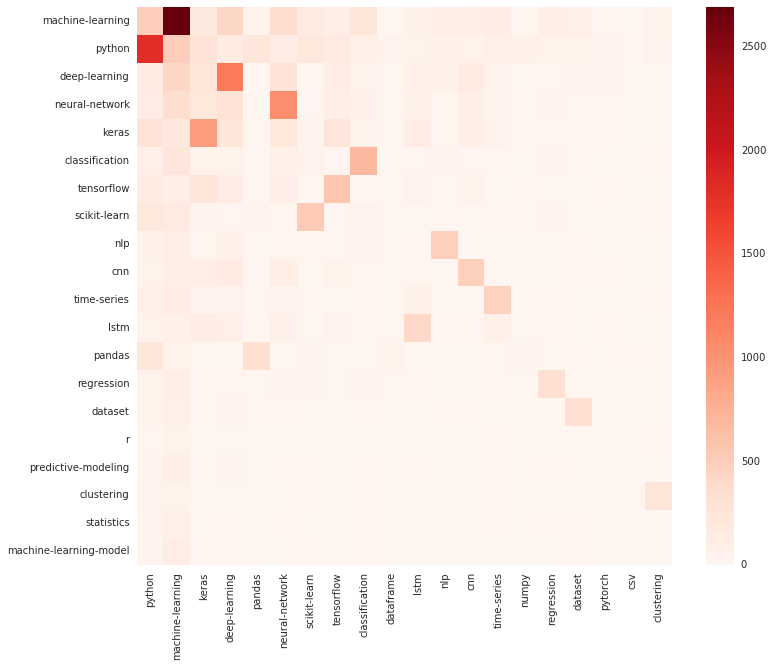

In [487]:
plt.figure(figsize=(12,10))
sns.heatmap(relations_most_popular, cmap='Reds')

We can see that the most popular tags that are found in the most viewed and most used of the questions database are machine-learning, python, deep-learning, keras, neural-network.

While this is a simple way of trying to identify the most popular tags, does this help show how tags are related?
The popular tags may just be ones that are used and/or viewed a lot and may not be directly related. 
Another aspect of this method is that some rows in the questions dataset use a group of tags, I.E more than 2. In these cases, the relationship between the group is not evaluated, only the relationship between two tags at a time. 

A way to get around this is through the use of association rules which allows correlation of multiple instances. 

# Is Deep Learning Just a Fad?

In [488]:
all_questions = pd.read_csv("all_questions.csv", parse_dates=['CreationDate'])

In [489]:
all_questions.head(4)

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>


In [490]:
all_questions['Tags'] = all_questions['Tags'].str.replace("^<|>$", "").str.split("><")

What is classified as a deep learning question?

For our purposes here, lets stick with a deep learning question being defined as having the following tags:
deep-learning, neural-network, keras, tensorflow, cnn, lstm, and scikit-learn. These are all names, frameworks, specific models, or libraries for deep-learning.

In [491]:
all_questions

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."
5,45428,2019-02-12 05:43:18,[cnn]
6,45430,2019-02-12 06:20:30,"[machine-learning, learning]"
7,45431,2019-02-12 07:26:56,[machine-learning]
8,45433,2019-02-12 08:56:23,"[python, keras, tensorflow, lstm]"
9,45434,2019-02-12 09:09:01,"[neural-network, feature-selection, mlp]"


In [492]:
def deep_learning_tag(tags):
    for tag in tags:
        if tag in ["neural-network","scikit-learn","cnn","deep-learning","keras", "tensorflow","lstm"]:
            return 1
    return 0          

In [493]:
all_questions["DeepLearning"] = all_questions['Tags'].apply(deep_learning_tag)

In [494]:
all_questions

,Id,CreationDate,Tags,DeepLearning
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0
3,45426,2019-02-12 04:51:49,[keras],1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0
5,45428,2019-02-12 05:43:18,[cnn],1
6,45430,2019-02-12 06:20:30,"[machine-learning, learning]",0
7,45431,2019-02-12 07:26:56,[machine-learning],0
8,45433,2019-02-12 08:56:23,"[python, keras, tensorflow, lstm]",1
9,45434,2019-02-12 09:09:01,"[neural-network, feature-selection, mlp]",1


We can now start to compare the deeplearning mentions versus time. Since the industry changes/updates frequently, lets change it by quarter. Additionally, we will remove 2020 since the year is not complete.

In [498]:
all_questions = all_questions.loc[all_questions["CreationDate"].dt.year < 2020]

In [499]:
def get_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month -1)// 3)+ 1)
    return "{y}Q{q}".format(y=year,q=quarter)
all_questions['Quarter'] = all_questions['CreationDate'].apply(get_quarter)

In [502]:
all_questions.head(4)

,Id,CreationDate,Tags,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,19Q1
3,45426,2019-02-12 04:51:49,[keras],1,19Q1


In [522]:
quarterly = all_questions.groupby("Quarter").agg({"DeepLearning": ['sum', 'size']})
quarterly.columns=["DeepLearningQuestions", "TotalQuestions"]

quarterly['DeepLearningRate'] = quarterly["DeepLearningQuestions"]/quarterly['TotalQuestions']
quarterly.reset_index(inplace=True)
quarterly

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
0,14Q2,9,157,0.057325
1,14Q3,13,189,0.068783
2,14Q4,21,216,0.097222
3,15Q1,18,190,0.094737
4,15Q2,28,284,0.098592
5,15Q3,45,311,0.144695
6,15Q4,66,382,0.172775
7,16Q1,110,516,0.213178
8,16Q2,109,518,0.210425
9,16Q3,161,585,0.275214


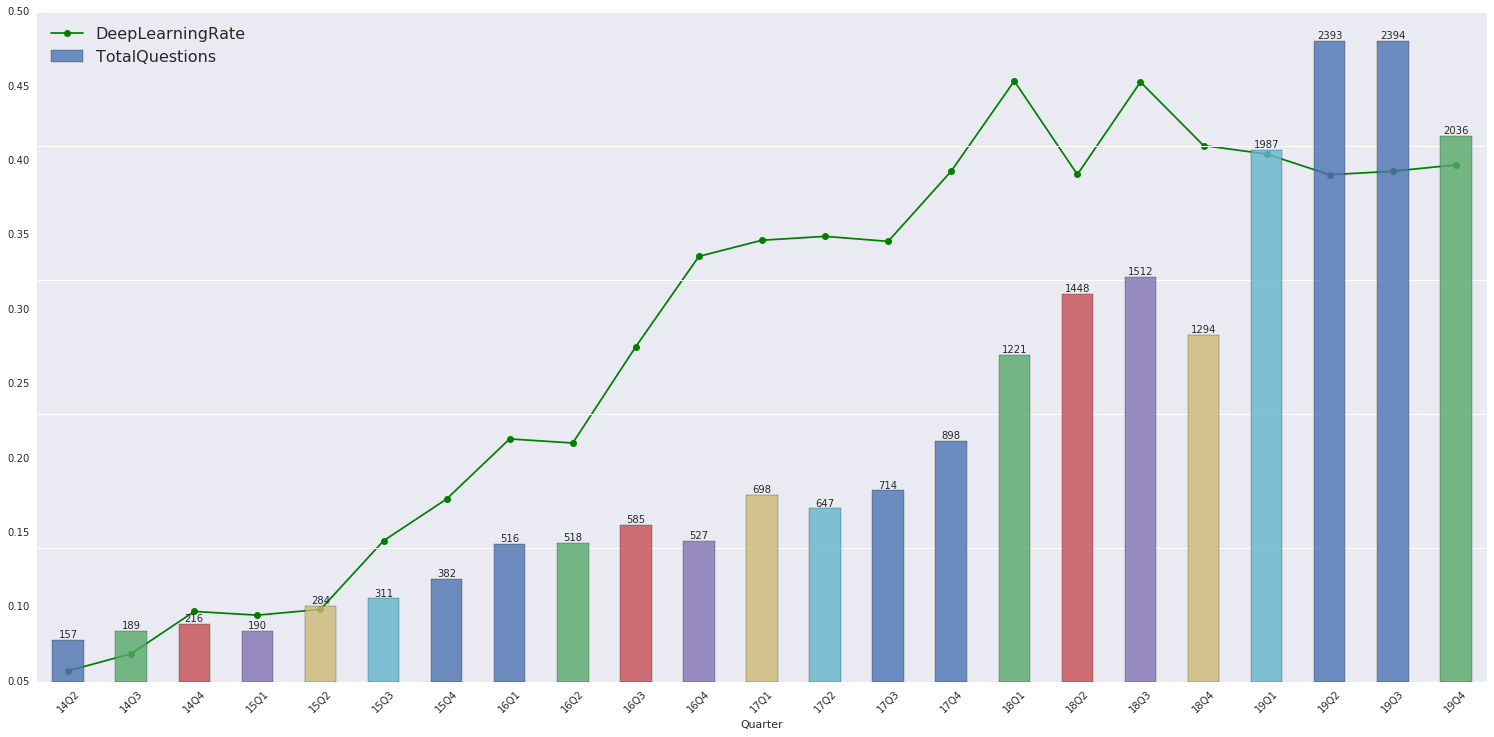

In [554]:
ax1 = quarterly.plot(x='Quarter', y="DeepLearningRate", kind='line', linestyle='-',marker='o',color='green',figsize=(26,12))

ax2 = quarterly.plot(x='Quarter', y="TotalQuestions", kind='bar',ax=ax1,secondary_y=True,alpha=0.8,rot=45)

#iterate through 'TotalQuestions' and add the value as text on the ax2 bars in the bar graph.

for index, value in quarterly["TotalQuestions"].iteritems():
    ax2.text(index, value, str(value), ha="center", va="bottom")
xlims = ax1.get_xlim()


# call get_legend_handles_lables func to put labels on and make legend

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 16})

#remove spines and tick parameters to top and right side

for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

We can see that interest in Deep Learning has risen overall and is now plateauing. However, this does not indicate that it will decrease!